Import Required Libraries

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

Load and Prepare Price Data

In [9]:
price_df = pd.read_csv("/content/eurusd_open_close_1d.csv", skiprows=2)
price_df.rename(columns={"Price": "Date", price_df.columns[1]: "Open", price_df.columns[2]: "Close"}, inplace=True)
price_df["Date"] = pd.to_datetime(price_df["Date"]).dt.date
price_df = price_df.sort_values("Date").reset_index(drop=True)

Calculate Technical Indicators

In [10]:
price_df['EMA_14'] = price_df['Close'].ewm(span=14, adjust=False).mean()
delta = price_df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
price_df['RSI_14'] = 100 - (100 / (1 + rs))
price_df.bfill(inplace=True)

Load and Process Sentiment Data

In [11]:
news_df = pd.read_csv("/content/news_sentiment_cleaned_labeled.csv")

def convert_timestamp(ts):
    ts = str(ts)
    if "ago" in ts:
        try:
            num, unit = ts.split()[0], ts.split()[1]
            num = int(num)
            if "minute" in unit:
                return datetime.now() - timedelta(minutes=num)
            elif "hour" in unit:
                return datetime.now() - timedelta(hours=num)
        except:
            return pd.NaT
    try:
        return pd.to_datetime(ts)
    except:
        return pd.NaT

news_df["Datetime"] = news_df["Timestamp"].apply(convert_timestamp)
news_df["Date"] = pd.to_datetime(news_df["Datetime"]).dt.date

sentiment_map = {"Positive": 1, "Neutral": 0, "Negative": -1, "positive": 1, "neutral": 0, "negative": -1}
for col in ["Sentiment_FinBERT", "Sentiment_NB", "Sentiment_SVM"]:
    news_df[f"Score_{col.split('_')[1]}"] = news_df[col].map(sentiment_map)

agg_sent = lambda method, tag: news_df[news_df["CurrencyTag"] == tag].groupby("Date")[f"Score_{method}"].mean()
finbert_eur = agg_sent("FinBERT", "EUR")
finbert_usd = agg_sent("FinBERT", "USD")
nb_eur = agg_sent("NB", "EUR")
nb_usd = agg_sent("NB", "USD")
svm_eur = agg_sent("SVM", "EUR")
svm_usd = agg_sent("SVM", "USD")


Prepare Dataset for LSTM

In [12]:
df = price_df.copy()
df["Sentiment"] = df["Date"].map(finbert_eur).fillna(0)
df['Next_Close'] = df['Close'].shift(-1)
df['Return'] = df['Next_Close'] - df['Close']
df['Target'] = df['Return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df.dropna(inplace=True)
features = ['Close', 'RSI_14', 'EMA_14', 'Sentiment']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

 Define PyTorch Dataset

In [13]:
SEQ_LEN = 5
class TimeSeriesDataset(Dataset):
    def __init__(self, data, features, target, seq_len):
        self.features = features
        self.data = data.reset_index(drop=True)
        self.target = target
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data.loc[idx:idx+self.seq_len-1, self.features].values.astype(np.float32)
        y = self.data.loc[idx+self.seq_len, self.target]
        return x, y

split_idx = int(len(df) * 0.8)
train_dataset = TimeSeriesDataset(df.iloc[:split_idx], features, 'Target', SEQ_LEN)
test_dataset = TimeSeriesDataset(df.iloc[split_idx:], features, 'Target', SEQ_LEN)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Define LSTM Model Architecture

In [14]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(input_size=len(features)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train LSTM Model

In [22]:
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), (y_batch + 1).to(device)
        optimizer.zero_grad()
        loss = criterion(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.7132
Epoch 2/10, Loss: 0.7146
Epoch 3/10, Loss: 0.7157
Epoch 4/10, Loss: 0.7133
Epoch 5/10, Loss: 0.7134
Epoch 6/10, Loss: 0.7124
Epoch 7/10, Loss: 0.7118
Epoch 8/10, Loss: 0.7080
Epoch 9/10, Loss: 0.7151
Epoch 10/10, Loss: 0.7098


Generate LSTM Predictions

In [16]:
def get_lstm_preds(model, dataset):
    model.eval()
    preds = []
    with torch.no_grad():
        for x_batch, _ in DataLoader(dataset, batch_size=64):
            x_batch = x_batch.to(device)
            pred = torch.argmax(model(x_batch), dim=1).cpu().numpy()
            preds.extend(pred - 1)
    return np.array(preds)

df_preds = pd.DataFrame(index=df.index[SEQ_LEN:])
df_preds['LSTM_Pred'] = get_lstm_preds(model, TimeSeriesDataset(df, features, 'Target', SEQ_LEN))
df.loc[df.index[SEQ_LEN:], 'LSTM_Pred'] = df_preds['LSTM_Pred'].values

Define Strategy Simulations

In [17]:
def simulate_strategy(model_name, eur_sent, usd_sent, hybrid=False):
    balance = 10000
    log = []
    df_sim = price_df.copy()
    df_sim['EUR'] = df_sim['Date'].map(eur_sent).fillna(0)
    df_sim['USD'] = df_sim['Date'].map(usd_sent).fillna(0)
    if hybrid:
        df_sim = df_sim.merge(df[['Date', 'LSTM_Pred']], on='Date', how='left').fillna(0)
    for i in range(len(df_sim)-1):
        row, next_row = df_sim.iloc[i], df_sim.iloc[i+1]
        action = "Hold"
        if row['EUR'] > 0.1 and row['USD'] < -0.1: action = "Buy"
        if row['EUR'] < -0.1 and row['USD'] > 0.1: action = "Sell"
        if hybrid:
            if (row['LSTM_Pred'] == 1 and action != "Buy") or (row['LSTM_Pred'] == -1 and action != "Sell"):
                action = "Hold"
        profit = 0
        if action != "Hold":
            entry, exit_ = row['Close'], next_row['Close']
            pips = (exit_ - entry)*10000 if action=="Buy" else (entry - exit_)*10000
            pips = max(min(pips, 60), -30)
            profit = (pips/10000) * (balance * 0.01 / (30/10000))
            balance += profit
        log.append({"Date": row['Date'], "Model": model_name, "Action": action, "Profit": profit, "Balance": balance})
    return pd.DataFrame(log)

Run and Compare All Strategies

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


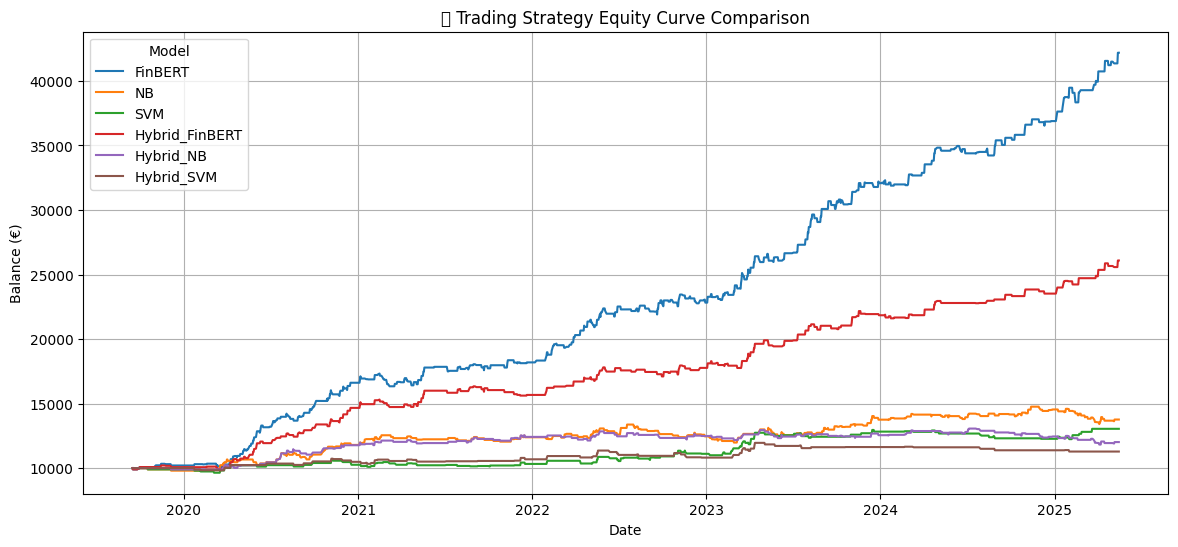

In [18]:
df1 = simulate_strategy("FinBERT", finbert_eur, finbert_usd)
df2 = simulate_strategy("NB", nb_eur, nb_usd)
df3 = simulate_strategy("SVM", svm_eur, svm_usd)
df4 = simulate_strategy("Hybrid_FinBERT", finbert_eur, finbert_usd, hybrid=True)
df5 = simulate_strategy("Hybrid_NB", nb_eur, nb_usd, hybrid=True)
df6 = simulate_strategy("Hybrid_SVM", svm_eur, svm_usd, hybrid=True)

final_df = pd.concat([df1, df2, df3, df4, df5, df6])

plt.figure(figsize=(14, 6))
sns.lineplot(data=final_df, x='Date', y='Balance', hue='Model')
plt.title("📉 Trading Strategy Equity Curve Comparison")
plt.xlabel("Date")
plt.ylabel("Balance (€)")
plt.grid(True)
plt.show()

Evaluate Strategy Performance

In [19]:
def evaluate_strategies(df):
    models = df['Model'].unique()
    for model in models:
        dfm = df[df['Model'] == model]
        initial_balance = 10000
        final_balance = dfm['Balance'].iloc[-1]
        net_profit = final_balance - initial_balance
        trades = dfm[dfm['Action'] != 'Hold']
        total_trades = trades.shape[0]
        wins = trades[trades['Profit'] > 0].shape[0]
        losses = trades[trades['Profit'] < 0].shape[0]
        win_rate = (wins / total_trades) * 100 if total_trades else 0
        profit_factor = trades[trades['Profit'] > 0]['Profit'].sum() / abs(trades[trades['Profit'] < 0]['Profit'].sum()) if losses else float('inf')

        print(f"\n📊 Results for {model}:")
        print(f"Initial Balance: €{initial_balance:.2f}")
        print(f"Final Balance: €{final_balance:.2f}")
        print(f"Net Profit: €{net_profit:.2f}")
        print(f"Total Trades: {total_trades}")
        print(f"Wins: {wins} | Losses: {losses}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Profit Factor: {profit_factor:.2f}")

Run evaluation

In [23]:
evaluate_strategies(final_df)


📊 Results for FinBERT:
Initial Balance: €10000.00
Final Balance: €42186.47
Net Profit: €32186.47
Total Trades: 361
Wins: 216 | Losses: 142
Win Rate: 59.83%
Profit Factor: 2.40

📊 Results for NB:
Initial Balance: €10000.00
Final Balance: €13767.44
Net Profit: €3767.44
Total Trades: 267
Wins: 128 | Losses: 139
Win Rate: 47.94%
Profit Factor: 1.27

📊 Results for SVM:
Initial Balance: €10000.00
Final Balance: €13047.37
Net Profit: €3047.37
Total Trades: 127
Wins: 66 | Losses: 61
Win Rate: 51.97%
Profit Factor: 1.60

📊 Results for Hybrid_FinBERT:
Initial Balance: €10000.00
Final Balance: €26089.64
Net Profit: €16089.64
Total Trades: 217
Wins: 129 | Losses: 87
Win Rate: 59.45%
Profit Factor: 2.57

📊 Results for Hybrid_NB:
Initial Balance: €10000.00
Final Balance: €12020.65
Net Profit: €2020.65
Total Trades: 172
Wins: 83 | Losses: 89
Win Rate: 48.26%
Profit Factor: 1.25

📊 Results for Hybrid_SVM:
Initial Balance: €10000.00
Final Balance: €11286.08
Net Profit: €1286.08
Total Trades: 75
Wins: 

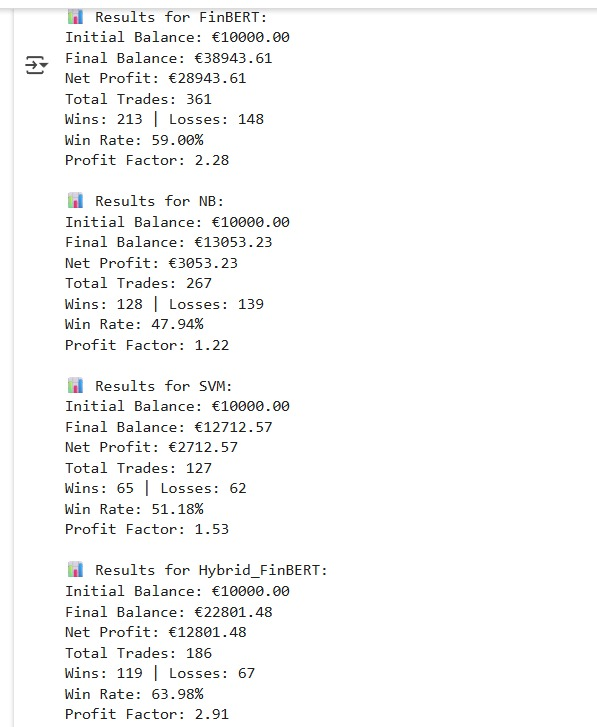